In [2]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
#from sklearn.grid_search import GridSearchCV   #Perforing grid search
from imblearn.over_sampling import SMOTE       #over sampling of minority class in imbalanced data
from imblearn.combine import SMOTEENN          #over sampling of minority class in imbalanced data
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score,average_precision_score,precision_recall_curve,precision_score

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_columns', 100)

/Users/venkatasravankanukolanu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# read the input files and look at the top few lines #
data_path = "/Users/venkatasravankanukolanu/Documents/Data Files/credit_fraud/"
data_df= pd.read_csv(data_path+"creditcard.csv")
data_df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


Since all the features except Time and Amount are principal components, we need to scale the features Time and Amount

In [4]:
data_df['std_amount'] = StandardScaler().fit_transform(data_df['Amount'].reshape(-1, 1))
data_df= data_df.drop(['Time','Amount'],axis=1)
data_df.head(2)

/Users/venkatasravankanukolanu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475


In [5]:
response='Class'
predictors=data_df.columns[data_df.columns != 'Class']

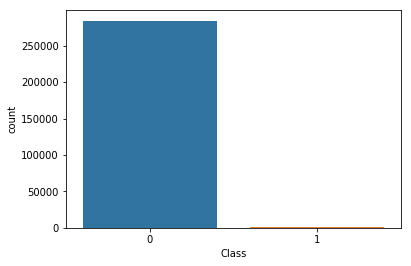

In [9]:
sns.countplot(x='Class', data=data_df)
plt.xticks(rotation='horizontal')
plt.show()

This plot clearly shows the data has high class imbalance. We need to train our model taking care of the class imbalance as we are interested in predicting the minority class.

#### Split the data as test and train

In [11]:
df_train, df_test = train_test_split(data_df, test_size=0.1, random_state=2,stratify=data_df[response])

### Random Forests

Random Forest trains multiple decesion trees and classifies the input based on a majority vote by the tress in the forest. Since the data set is highly skewed in class distribution, we can handle that problem in multiple ways:
1. Adding penality on minority class missclassification.
2. Balancing the classes using ENN, SMOTE, SMOTEENN and SMOTETomek
3. Adjusting the threshold probability for classification

Here we will use Random Forests along with adding penality for minority class missclassification. <br>
We will start my defining 2 functions i.e. 
1. Function to train random forest with given parameters and plot the results on a test data set. 
2. Function to evaluate a given random forest model by K-fold cross validation

In [47]:
##Function for training models and testing on a test set. if plot is True, it plots a PRC curve for 
##training and test sets and finds the threshold where (precision*recall) is maximum.
def modelfit(alg,dtrain,dtest,predictors,response,plot=True):
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[response])
        
    #Predict training set:
    dtrain_pred = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    dtest_pred = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
    
    prf_train=precision_recall_fscore_support(dtrain[response], dtrain_pred,pos_label =1, average ='binary')
    prf_test=precision_recall_fscore_support(dtest[response], dtest_pred,pos_label =1, average ='binary')
    area_prc_test=average_precision_score(dtest[response], dtest_predprob,average=None)
    area_prc_train=average_precision_score(dtrain[response], dtrain_predprob,average=None)
    
    
    precision_train, recall_train, thr_train = precision_recall_curve(dtrain[response], dtrain_predprob,pos_label =1)
    precision_test, recall_test, thr_test = precision_recall_curve(dtest[response],dtest_predprob,pos_label =1)
    
    #area, thr = ((precision_test)*(recall_test)), thr_test
    #idx= np.argmax(area)
    
    
    print "Model report on training data:"
    print "Train: Precision: %.4g" % (prf_train[0]*100)
    print "Train: Recall : %.4g" % (prf_train[1]*100)
    print "Average Precision (Train): %f" % (area_prc_train*100)
    print "\nModel report on test data:"
    print "Test: Precision: %.4g" % (prf_test[0]*100)
    print "Test: Recall : %.4g" % (prf_test[1]*100)
    print "Average Precision (Trest): %f" % (area_prc_test*100)

    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(recall_test, precision_test, color='coral',label=' Test PR-Curve')
        plt.plot(recall_train, precision_train, color='green',label=' Train PR-Curve')
        #plt.plot([0, 1], [0, 1], 'k--')
        #plt.plot([0,recall_test[idx]], [precision_test[idx],precision_test[idx]], 'k--', color='blue')
        #plt.plot([recall_test[idx],recall_test[idx]], [0,precision_test[idx]], 'k--', color='blue')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.show()
        
        #print("Using a threshold of %.3f " % thr[idx] + "guarantees a precision of %.3f " % precision[idx] +  
                  #"and a recall of %.3f" % recall[idx])

In [15]:
#Function for K-Fold Stratified Cross_validation of any model
def cv_modelfit(alg,dtrain,predictors,response,cvfolds):

    skf = StratifiedKFold(n_splits=cvfolds,random_state=2)
    cv_results = np.zeros((cvfolds, 3))
    for i, (train_index, test_index) in enumerate(skf.split(dtrain[predictors],dtrain[response])):
        for j in range(0,3):
            cvtrain=df_train.iloc[train_index]
            cvtest=df_train.iloc[test_index]

            #Fit the algorithm on the data
            alg.fit(cvtrain[predictors], cvtrain[response])

            #Predict training set:
            dtrain_pred = alg.predict(cvtrain[predictors])
            dtrain_predprob = alg.predict_proba(cvtrain[predictors])[:,1]

            dtest_pred = alg.predict(cvtest[predictors])
            dtest_predprob = alg.predict_proba(cvtest[predictors])[:,1]

            prf_train=precision_recall_fscore_support(cvtrain[response], dtrain_pred,pos_label =1, average ='binary')
            prf_test=precision_recall_fscore_support(cvtest[response], dtest_pred,pos_label =1, average ='binary')
            area_prc_test=average_precision_score(cvtest[response], dtest_predprob,average=None)
            area_prc_train=average_precision_score(cvtrain[response], dtrain_predprob,average=None)


            cvr=[prf_test[0],prf_test[1],area_prc_test]
            cv_results[i,j]=cvr[j]

    print "Mean CV Test Precision: %.4g" % (cv_results[:,0].mean()*100)
    print "Mean CV Test Recall: %.4g" % (cv_results[:,1].mean()*100)
    print "Std.Devation of CV Test Precision: %.4g" % (cv_results[:,0].std()*100)
    print "Std.Devation of CV Test Recall: %.4g" % (cv_results[:,1].std()*100)

### Baseline Random Forest Model

This baseline model is trained on 500 decision tress with a class weight of 3:1 i.e. minority class missclassification is 3 times penalized to that if majority class. We will start with a 3:1 ratio since our main approach is to add penality else we should start with 1:1 ratio.

In [16]:
rf1=RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_split=2, 
                           min_samples_leaf=1, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           bootstrap=True, oob_score=True, n_jobs=-1, random_state=2, verbose=0, 
                           warm_start=False, class_weight={0:1,1:3})

Model report on training data:
Train: Precision: 92.69
Train: Recall : 80.14
Average Precision (Train): 85.117381

Model report on test data:
Test: Precision: 82.98
Test: Recall : 79.59
Average Precision (Trest): 81.891900


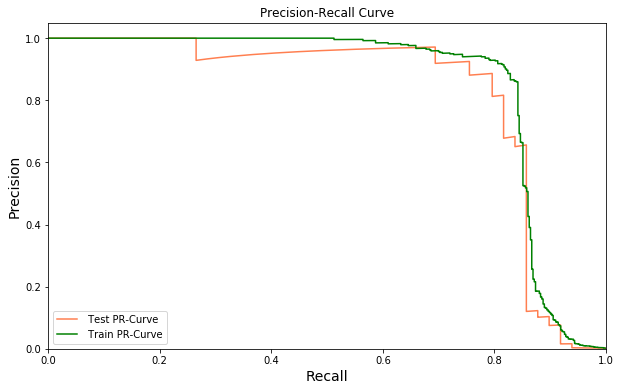

In [49]:
modelfit(rf1,df_train, df_test,predictors,response,plot=True)

### Model Evaluation by 10-fold Cross-Validation

In [235]:
cv_modelfit(rf1,df_train,predictors,response,10)

Mean CV Test Precision: 84.08
Mean CV Test Recall: 73.6
Std.Devation of CV Test Precision: 8.182
Std.Devation of CV Test Recall: 6.434


### Hyperparameter Tuning of Random Forest

We will use GridSearch to find the optimal parameters for random forest. Will first tune 1. Number of estimators(n_estimators) and 2. Number of features to consider for split(max_features). We will use Gini Impurity as the criterion since it is easy to compute compared to Entropy and chose the parameters with lowest Gini Impurity value. <br>
Let us tune these 2 parameters in multiple steps.

In [17]:
from sklearn.model_selection import GridSearchCV
def grid_tune(param_test,scores):
    
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print

        clf = GridSearchCV(RandomForestClassifier(n_estimators=275,max_features='sqrt',max_depth=10, min_samples_split=2, 
                               min_samples_leaf=3, max_leaf_nodes=30, min_impurity_decrease=0.0, 
                               bootstrap=True, oob_score=True, n_jobs=-1, random_state=2, verbose=0, 
                               warm_start=False, class_weight={0:1,1:200}), param_test, cv=5,
                           scoring=score)
        clf.fit(df_train[predictors], df_train[response])

        print("Best parameters set found on development set:")
        print
        print(clf.best_params_,clf.best_score_)
        print
        print("Grid scores on development set:")
        print
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))

In [267]:
# Set to n_estimators to the tuned values from cross-validation
scores1 = ['recall','precision']
param_test1 = {
 'n_estimators':range(1,901,300),
 'max_features':['log2', 'sqrt']
}
grid_tune(param_test1,scores1)

# Tuning hyper-parameters for recall
()
Best parameters set found on development set:
()
{'max_features': 'sqrt', 'n_estimators': 301}
()
Grid scores on development set:
()
0.709 (+/-0.138) for {'max_features': 'log2', 'n_estimators': 1}
0.756 (+/-0.058) for {'max_features': 'log2', 'n_estimators': 301}
0.759 (+/-0.063) for {'max_features': 'log2', 'n_estimators': 601}
0.693 (+/-0.163) for {'max_features': 'sqrt', 'n_estimators': 1}
0.772 (+/-0.074) for {'max_features': 'sqrt', 'n_estimators': 301}
0.763 (+/-0.068) for {'max_features': 'sqrt', 'n_estimators': 601}
()
# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'max_features': 'log2', 'n_estimators': 601}
()
Grid scores on development set:
()
0.839 (+/-0.054) for {'max_features': 'log2', 'n_estimators': 1}
0.896 (+/-0.040) for {'max_features': 'log2', 'n_estimators': 301}
0.900 (+/-0.040) for {'max_features': 'log2', 'n_estimators': 601}
0.797 (+/-0.157) for {'max_features': 'sqrt', 'n_es

In [269]:
# Set to n_estimators to the tuned values from cross-validation
scores1 = ['recall','precision']
param_test2 = {
 'n_estimators':range(200,400,25),
 'max_features':['log2', 'sqrt']
}
grid_tune(param_test2,scores1)

# Tuning hyper-parameters for recall
()
Best parameters set found on development set:

({'max_features': 'sqrt', 'n_estimators': 275}, 0.7742849203210381)

Grid scores on development set:

0.759 (+/-0.063) for {'max_features': 'log2', 'n_estimators': 200}
0.761 (+/-0.066) for {'max_features': 'log2', 'n_estimators': 225}
0.759 (+/-0.063) for {'max_features': 'log2', 'n_estimators': 250}
0.761 (+/-0.056) for {'max_features': 'log2', 'n_estimators': 275}
0.759 (+/-0.063) for {'max_features': 'log2', 'n_estimators': 300}
0.759 (+/-0.063) for {'max_features': 'log2', 'n_estimators': 325}
0.759 (+/-0.063) for {'max_features': 'log2', 'n_estimators': 350}
0.759 (+/-0.063) for {'max_features': 'log2', 'n_estimators': 375}
0.772 (+/-0.074) for {'max_features': 'sqrt', 'n_estimators': 200}
0.770 (+/-0.069) for {'max_features': 'sqrt', 'n_estimators': 225}
0.772 (+/-0.074) for {'max_features': 'sqrt', 'n_estimators': 250}
0.774 (+/-0.077) for {'max_features': 'sqrt', 'n_estimators': 275}
0.770 (

Since setting the n_estimators to 275 and max_features to sqareroot of number of features gives a recall of 77.4% and precision of 89.8%, we will use these parameters. Next let us tune max_depth and min_samples_split to avoid overfitting of the trees.

In [18]:
scores1 = ['recall','precision']
param_test3 = {'max_depth':range(2,15,4)}
grid_tune(param_test3,scores1)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

({'max_depth': 10}, 0.7832483766423053)

Grid scores on development set:

0.652 (+/-0.024) for {'max_depth': 2}
0.779 (+/-0.076) for {'max_depth': 6}
0.783 (+/-0.090) for {'max_depth': 10}
0.781 (+/-0.095) for {'max_depth': 14}
# Tuning hyper-parameters for precision

Best parameters set found on development set:

({'max_depth': 14}, 0.9523418788018786)

Grid scores on development set:

0.863 (+/-0.033) for {'max_depth': 2}
0.920 (+/-0.051) for {'max_depth': 6}
0.950 (+/-0.044) for {'max_depth': 10}
0.952 (+/-0.042) for {'max_depth': 14}


In [19]:
scores2 = ['recall']
param_test4 = {'max_depth':range(8,12,1)}
grid_tune(param_test4,scores2)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

({'max_depth': 10}, 0.7832483766423053)

Grid scores on development set:

0.781 (+/-0.077) for {'max_depth': 8}
0.781 (+/-0.086) for {'max_depth': 9}
0.783 (+/-0.090) for {'max_depth': 10}
0.781 (+/-0.086) for {'max_depth': 11}


We can clearly see that max_depth of 10 gives a recall values of 78.3% and precision of 95%. Now let us tune min_samples_split

In [20]:
scores1 = ['recall','precision']
param_test5 = {'min_samples_split':range(2,102,25)}
grid_tune(param_test5,scores1)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

({'min_samples_split': 77}, 0.7765321463999771)

Grid scores on development set:

0.774 (+/-0.077) for {'min_samples_split': 2}
0.772 (+/-0.074) for {'min_samples_split': 27}
0.777 (+/-0.069) for {'min_samples_split': 52}
0.777 (+/-0.072) for {'min_samples_split': 77}
# Tuning hyper-parameters for precision

Best parameters set found on development set:

({'min_samples_split': 2}, 0.8976160048115589)

Grid scores on development set:

0.898 (+/-0.029) for {'min_samples_split': 2}
0.868 (+/-0.025) for {'min_samples_split': 27}
0.862 (+/-0.023) for {'min_samples_split': 52}
0.860 (+/-0.016) for {'min_samples_split': 77}


In [21]:
scores1 = ['recall','precision']
param_test6 = {'min_samples_leaf':range(1,13,2)}
grid_tune(param_test6,scores1)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

({'min_samples_leaf': 3}, 0.7765321463999771)

Grid scores on development set:

0.774 (+/-0.077) for {'min_samples_leaf': 1}
0.777 (+/-0.072) for {'min_samples_leaf': 3}
0.774 (+/-0.087) for {'min_samples_leaf': 5}
0.774 (+/-0.068) for {'min_samples_leaf': 7}
0.774 (+/-0.077) for {'min_samples_leaf': 9}
0.774 (+/-0.071) for {'min_samples_leaf': 11}
# Tuning hyper-parameters for precision

Best parameters set found on development set:

({'min_samples_leaf': 9}, 0.8998944324902359)

Grid scores on development set:

0.898 (+/-0.029) for {'min_samples_leaf': 1}
0.898 (+/-0.029) for {'min_samples_leaf': 3}
0.893 (+/-0.030) for {'min_samples_leaf': 5}
0.898 (+/-0.024) for {'min_samples_leaf': 7}
0.900 (+/-0.031) for {'min_samples_leaf': 9}
0.888 (+/-0.038) for {'min_samples_leaf': 11}


In [22]:
param_test7 = {'min_samples_leaf':[1,2,3]}
grid_tune(param_test7,scores1)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

({'min_samples_leaf': 2}, 0.7765321463999771)

Grid scores on development set:

0.774 (+/-0.077) for {'min_samples_leaf': 1}
0.777 (+/-0.080) for {'min_samples_leaf': 2}
0.777 (+/-0.072) for {'min_samples_leaf': 3}
# Tuning hyper-parameters for precision

Best parameters set found on development set:

({'min_samples_leaf': 3}, 0.8978869662309431)

Grid scores on development set:

0.898 (+/-0.029) for {'min_samples_leaf': 1}
0.898 (+/-0.030) for {'min_samples_leaf': 2}
0.898 (+/-0.029) for {'min_samples_leaf': 3}


Since min_samples_leaf set to 3 gives a recall of 77.6% and a precision of 89.7%, will set the parameter to 2. Let us tune max_leaf_nodes.

In [24]:
param_test8 = {'max_leaf_nodes':range(2,23,4)}
grid_tune(param_test8,scores1)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

({'max_leaf_nodes': 22}, 0.7765575943944659)

Grid scores on development set:

0.503 (+/-0.066) for {'max_leaf_nodes': 2}
0.722 (+/-0.049) for {'max_leaf_nodes': 6}
0.759 (+/-0.063) for {'max_leaf_nodes': 10}
0.768 (+/-0.070) for {'max_leaf_nodes': 14}
0.777 (+/-0.083) for {'max_leaf_nodes': 18}
0.777 (+/-0.083) for {'max_leaf_nodes': 22}
# Tuning hyper-parameters for precision

Best parameters set found on development set:

({'max_leaf_nodes': 22}, 0.916902401855839)

Grid scores on development set:

0.851 (+/-0.033) for {'max_leaf_nodes': 2}
0.865 (+/-0.037) for {'max_leaf_nodes': 6}
0.870 (+/-0.037) for {'max_leaf_nodes': 10}
0.872 (+/-0.037) for {'max_leaf_nodes': 14}
0.910 (+/-0.047) for {'max_leaf_nodes': 18}
0.917 (+/-0.048) for {'max_leaf_nodes': 22}


In [25]:
param_test9 = {'max_leaf_nodes':range(18,27,4)}
grid_tune(param_test9,scores2)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

({'max_leaf_nodes': 26}, 0.7788048204734048)

Grid scores on development set:

0.777 (+/-0.083) for {'max_leaf_nodes': 18}
0.777 (+/-0.083) for {'max_leaf_nodes': 22}
0.779 (+/-0.076) for {'max_leaf_nodes': 26}


In [26]:
param_test10 = {'max_leaf_nodes':range(26,44,4)}
grid_tune(param_test10,scores2)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

({'max_leaf_nodes': 30}, 0.7810520465523438)

Grid scores on development set:

0.779 (+/-0.076) for {'max_leaf_nodes': 26}
0.781 (+/-0.080) for {'max_leaf_nodes': 30}
0.781 (+/-0.080) for {'max_leaf_nodes': 34}
0.781 (+/-0.080) for {'max_leaf_nodes': 38}
0.781 (+/-0.080) for {'max_leaf_nodes': 42}


In [27]:
param_test11 = {'max_leaf_nodes':range(5,106,25)}
grid_tune(param_test11,scores2)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

({'max_leaf_nodes': 30}, 0.7810520465523438)

Grid scores on development set:

0.700 (+/-0.060) for {'max_leaf_nodes': 5}
0.781 (+/-0.080) for {'max_leaf_nodes': 30}
0.781 (+/-0.080) for {'max_leaf_nodes': 55}
0.781 (+/-0.080) for {'max_leaf_nodes': 80}
0.781 (+/-0.080) for {'max_leaf_nodes': 105}


We will set max_leaf_nodes to 30.

In [28]:
scores1 = ['recall','precision']
param_test12 = {'class_weight':[{0:1,1:1},{0:1,1:2},{0:1,1:3},{0:1,1:10},'balanced']}
grid_tune(param_test12,scores1)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

({'class_weight': 'balanced'}, 0.855541331085685)

Grid scores on development set:

0.725 (+/-0.053) for {'class_weight': {0: 1, 1: 1}}
0.761 (+/-0.066) for {'class_weight': {0: 1, 1: 2}}
0.774 (+/-0.077) for {'class_weight': {0: 1, 1: 3}}
0.792 (+/-0.092) for {'class_weight': {0: 1, 1: 10}}
0.856 (+/-0.097) for {'class_weight': 'balanced'}
# Tuning hyper-parameters for precision

Best parameters set found on development set:

({'class_weight': {0: 1, 1: 1}}, 0.9249570215207621)

Grid scores on development set:

0.925 (+/-0.040) for {'class_weight': {0: 1, 1: 1}}
0.916 (+/-0.041) for {'class_weight': {0: 1, 1: 2}}
0.898 (+/-0.029) for {'class_weight': {0: 1, 1: 3}}
0.864 (+/-0.038) for {'class_weight': {0: 1, 1: 10}}
0.488 (+/-0.095) for {'class_weight': 'balanced'}


In [29]:
scores1 = ['recall','precision']
param_test13 = {'class_weight':[{0:1,1:10},{0:1,1:20},{0:1,1:30},{0:1,1:50},{0:1,1:100}]}
grid_tune(param_test13,scores1)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

({'class_weight': {0: 1, 1: 100}}, 0.8216548039401784)

Grid scores on development set:

0.792 (+/-0.092) for {'class_weight': {0: 1, 1: 10}}
0.801 (+/-0.084) for {'class_weight': {0: 1, 1: 20}}
0.810 (+/-0.072) for {'class_weight': {0: 1, 1: 30}}
0.815 (+/-0.058) for {'class_weight': {0: 1, 1: 50}}
0.822 (+/-0.060) for {'class_weight': {0: 1, 1: 100}}
# Tuning hyper-parameters for precision

Best parameters set found on development set:

({'class_weight': {0: 1, 1: 10}}, 0.8640012179401789)

Grid scores on development set:

0.864 (+/-0.038) for {'class_weight': {0: 1, 1: 10}}
0.853 (+/-0.030) for {'class_weight': {0: 1, 1: 20}}
0.855 (+/-0.047) for {'class_weight': {0: 1, 1: 30}}
0.844 (+/-0.063) for {'class_weight': {0: 1, 1: 50}}
0.807 (+/-0.080) for {'class_weight': {0: 1, 1: 100}}


In [30]:
scores1 = ['recall','precision']
param_test14 = {'class_weight':[{0:1,1:150},{0:1,1:200},{0:1,1:500},{0:1,1:1000}]}
grid_tune(param_test14,scores1)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

({'class_weight': {0: 1, 1: 1000}}, 0.8600612312380517)

Grid scores on development set:

0.826 (+/-0.059) for {'class_weight': {0: 1, 1: 150}}
0.838 (+/-0.076) for {'class_weight': {0: 1, 1: 200}}
0.853 (+/-0.098) for {'class_weight': {0: 1, 1: 500}}
0.860 (+/-0.088) for {'class_weight': {0: 1, 1: 1000}}
# Tuning hyper-parameters for precision

Best parameters set found on development set:

({'class_weight': {0: 1, 1: 150}}, 0.7805500536523068)

Grid scores on development set:

0.781 (+/-0.092) for {'class_weight': {0: 1, 1: 150}}
0.771 (+/-0.085) for {'class_weight': {0: 1, 1: 200}}
0.562 (+/-0.109) for {'class_weight': {0: 1, 1: 500}}
0.219 (+/-0.020) for {'class_weight': {0: 1, 1: 1000}}


Based on what we see from the gridsearch on different values of class weights, setting a class weight of 1:200 will give us a recall value of 83.8% and a precision value of 77.1%. **This has to be adjusted according to the needs of the business while solving the problem.** <br>
The tuned random forest classifier for this classification problem is:

In [42]:
rf_tuned=RandomForestClassifier(n_estimators=275,max_features='sqrt',max_depth=10, min_samples_split=2, 
                               min_samples_leaf=3, max_leaf_nodes=30, min_impurity_decrease=0.0, 
                               bootstrap=True, oob_score=True, n_jobs=-1, random_state=2, verbose=0, 
                               warm_start=False, class_weight={0:1,1:200})

### 10-fold Cross Validation on the tuned model

In [43]:
cv_modelfit(rf_tuned,df_train,predictors,response,10)

Mean CV Test Precision: 71.04
Mean CV Test Recall: 84.41
Std.Devation of CV Test Precision: 6.989
Std.Devation of CV Test Recall: 5.979


The 10-fold cross validated test mean recall is 84.4% and 10-fold cross validated test mean precision is 71.0%. This means the fraudulent transactions are correctly predicted as fraud 84.4% of the time and 71.0% of those predicted as fraud are actually fraud. <br>

### Testing the predctive model on test data

Model report on training data:
Train: Precision: 70.41
Train: Recall : 89.16
Average Precision (Train): 75.524495

Model report on test data:
Test: Precision: 65.62
Test: Recall : 85.71
Average Precision (Trest): 69.204245


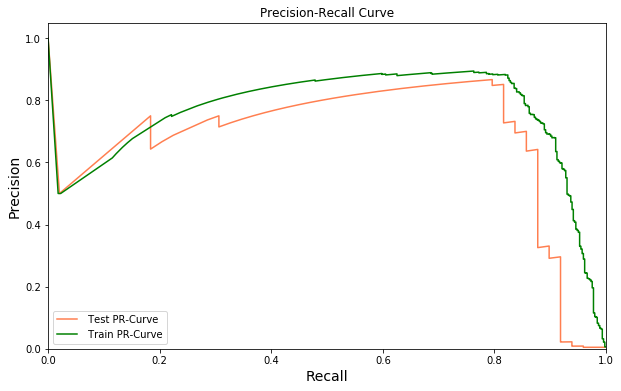

In [48]:
modelfit(rf_tuned,df_train, df_test,predictors,response,plot=True)

The model predicted the fraudulent transactions in the test data with a recall of 85.7% and a precision of 65.6% which are within one standard deviation from the estimated 10-fold cross validation values. 